In [1]:
import os
import numpy as np
from osgeo import gdal
from scipy.stats import theilslopes
import matplotlib.pyplot as plt

In [5]:
# --- PARAMETERS ---
# Folder containing your 26 predicted DDI .tif files
raster_folder = r"E:\Vighjayesh\2025 to 2050\Perdicted DMI\PredictedDMI_26_rastors" 

In [7]:
# Get list of raster file paths
raster_files = sorted([
    os.path.join(raster_folder, f)
    for f in os.listdir(raster_folder)
    if f.endswith(".tif")
])

print(f"Found {len(raster_files)} raster files.")

Found 26 raster files.


In [9]:
# --- READ ALL RASTERS INTO STACK ---
stack = []

for i, file in enumerate(raster_files):
    ds = gdal.Open(file)
    band = ds.GetRasterBand(1).ReadAsArray()
    stack.append(band)
    if i == 0:
        geo = ds.GetGeoTransform()
        proj = ds.GetProjection()
        cols = ds.RasterXSize
        rows = ds.RasterYSize
    ds = None

stack = np.array(stack)  # Shape: (26, rows, cols)
print("Stack shape:", stack.shape)

Stack shape: (26, 2489, 2948)


In [13]:
from numba import njit, prange
from scipy.stats import theilslopes
import numpy as np

# Convert stack to float32 if not already
stack = stack.astype(np.float32)

# --- NEW: Fast Parallel Sen's Slope ---
@njit(parallel=True)
def calculate_slope_parallel(stack):
    bands, rows, cols = stack.shape
    slope_arr = np.full((rows, cols), np.nan, dtype=np.float32)
    years = np.arange(bands)

    for i in prange(rows):
        for j in range(cols):
            pixel_series = stack[:, i, j]
            if np.all(np.isfinite(pixel_series)):
                # Manually compute Theil-Sen slope (nonparametric)
                slopes = []
                for m in range(len(pixel_series)):
                    for n in range(m + 1, len(pixel_series)):
                        dx = years[n] - years[m]
                        dy = pixel_series[n] - pixel_series[m]
                        if dx != 0:
                            slopes.append(dy / dx)
                if slopes:
                    slope_arr[i, j] = np.median(np.array(slopes))
    return slope_arr

# --- CALL FUNCTION ---
import time
start = time.time()
slope_array = calculate_slope_parallel(stack)
end = time.time()

print(f"Slope calculation finished in {end - start:.2f} seconds")


Slope calculation finished in 8.93 seconds


In [15]:
# --- SAVE THE SLOPE RASTER ---
output_path = os.path.join(raster_folder, "senseslope_ddi_trend.tif")

driver = gdal.GetDriverByName("GTiff")
out_ds = driver.Create(output_path, cols, rows, 1, gdal.GDT_Float32)
out_ds.SetGeoTransform(geo)
out_ds.SetProjection(proj)
out_ds.GetRasterBand(1).WriteArray(slope_array)
out_ds.GetRasterBand(1).SetNoDataValue(np.nan)
out_ds.FlushCache()
out_ds = None

print(f"Sen’s slope raster saved to: {output_path}")

Sen’s slope raster saved to: E:\Vighjayesh\2025 to 2050\Perdicted DMI\PredictedDMI_26_rastors\senseslope_ddi_trend.tif


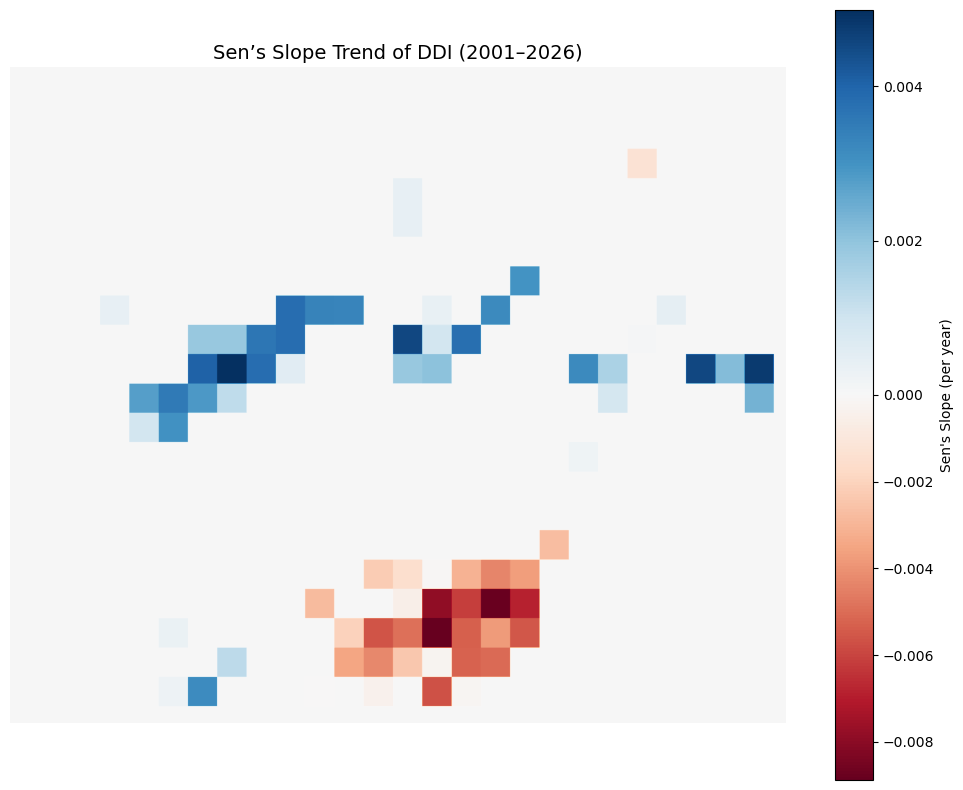

In [19]:
# Visualising the trend

import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
from matplotlib.colors import TwoSlopeNorm

# ---- Load the raster using GDAL ----
slope_raster_path = r"E:\Vighjayesh\2025 to 2050\Perdicted DMI\PredictedDMI_26_rastors\senseslope_ddi_trend.tif"
ds = gdal.Open(slope_raster_path)
slope_array = ds.ReadAsArray()

# ---- Set up diverging colormap ----
vmin = np.nanmin(slope_array)
vmax = np.nanmax(slope_array)
vcenter = 0  # Center at 0 = stable trend

norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# ---- Plot the slope map ----
plt.figure(figsize=(10, 8))
plt.imshow(slope_array, cmap='RdBu', norm=norm)
plt.title("Sen’s Slope Trend of DDI (2001–2026)", fontsize=14)
plt.colorbar(label="Sen's Slope (per year)")
plt.axis('off')
plt.tight_layout()
plt.show()
